In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import numpy as np 
import pandas as pd 

import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import tree
from sklearn.metrics import f1_score, mean_squared_error, r2_score

from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn import linear_model
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint


# display warnings only the first time
import warnings
warnings.filterwarnings('ignore')

Traffic data from https://maps-semcog.opendata.arcgis.com/datasets/SEMCOG::traffic-volume/about

In [8]:
se_traff = pd.read_csv('se_mi_traffic_volume.csv')

Crash data from https://maps-semcog.opendata.arcgis.com/datasets/SEMCOG::2016-2020-crash-locations/about

In [9]:
se_crash = pd.read_csv('se_mi_2016-2020_crash_locations.csv')

In [10]:
se_crash_county_counts = se_crash.groupby(['CNTNAME']).size().reset_index(name='total_crashes')

If main year column is blank, get from second or latest year for that road segment. Then the next cell drops the if it is still 0

In [11]:
se_traff[se_traff['AADTYEAR'] == 0].shape

(8341, 51)

In [12]:
se_traff['AADTYEAR'] = np.where(se_traff['AADTYEAR'] == 0, se_traff['AADT_MS2_Y'], se_traff['AADTYEAR'])

In [13]:
se_traff['AADTYEAR'] = np.where(se_traff['AADTYEAR'] == 0, se_traff['LATEST_COU'], se_traff['AADTYEAR'])

In [14]:
se_traff[se_traff['AADTYEAR'] == 0].shape

(2967, 51)

In [15]:
se_traff = se_traff[se_traff['AADTYEAR'] != 0]

In [16]:
se_crash_county_counts

,CNTNAME,total_crashes
0,Livingston,23140
1,Macomb,118248
2,Monroe,18375
3,Oakland,191966
4,St. Clair,18355
5,Washtenaw,52547
6,Wayne,259138


Using totals of average anual daily traffic and vehicle miles traveled by county for gauging their overall traffic

In [17]:
aadt_sum = se_traff.groupby('CNTNAME')['AADT'].sum()
vmt_sum = se_traff.groupby('CNTNAME')['VMT'].sum()

Population data manually pulled from https://www.census.gov/library/stories/state-by-state/michigan-population-change-between-census-decade.html

In [18]:
county_pops = pd.read_csv('county_populations.csv')

In [19]:
county_pops

,CNTNAME,POP
0,Wayne,1793561
1,Oakland,1274395
2,Macomb,881217
3,Washtenaw,372258
4,Livingston,193866
5,Monroe,154809
6,St. Clair,160383


In [21]:
merged = pd.merge(pd.merge(pd.merge(aadt_sum,vmt_sum,on='CNTNAME'),se_crash_county_counts,on='CNTNAME'),county_pops,on='CNTNAME')


Compare counties' traffic and crashes to see if they are proportional to populations, they roughly do

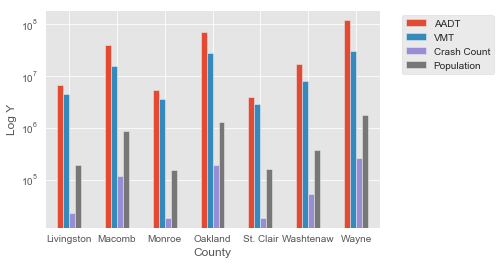

In [278]:
merged.plot.bar(x='CNTNAME', logy=True)
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', labels=['AADT', 'VMT', 'Crash Count','Population'])
plt.xlabel('County')
plt.ylabel('Log Y')
plt.savefig('county_breakdown.png', bbox_inches='tight')
plt.show()

In [71]:
se_crash.columns

Index(['X', 'Y', 'FID', 'CRASHID', 'DATE_FULL', 'YEAR', 'MONTH', 'DAY',
       'WEEKDAY', 'HOUR', 'JURIS', 'PROPDAMG', 'KCOUNT', 'ACOUNT', 'BCOUNT',
       'CCOUNT', 'OCCUPANTS', 'UNITS', 'CRSHTYPEO', 'DEER', 'SCHOOLBUS',
       'HITNRUN', 'WEATHER', 'LIGHTING', 'ROADCONDIT', 'ROADLANES',
       'SPEEDLIMIT', 'SURFACE', 'ALCOHOL', 'DRUG', 'PEDESTRIAN', 'BICYCLE',
       'MOTORCYCLE', 'TRAIN', 'COMMERCIAL', 'EMERGENCY', 'WORK_ZONE',
       'DISTRACTED', 'MAINROAD', 'INTERROAD', 'XCORD', 'YCORD', 'HWY_CLSS_C',
       'ELDERLY', 'YOUNG', 'DIS_CTRL_I', 'REDLIGHTRU', 'FALINKID',
       'HIGH_SEVER', 'LANEDEPART', 'INTR_INVL_', 'SEMMCD', 'PR', 'MP',
       'TIME_FULL', 'CNTNAME', 'COMMUNITY', 'NFC', 'SECONDARY', 'GlobalID'],
      dtype='object')

In [80]:
se_traff.columns

Index(['FID', 'AADT', 'AADTR', 'AADTTYPE', 'AADTYEAR', 'BMP', 'CNTNAME',
       'CNTNUM', 'CNTNAME2', 'CNTNUM2', 'COMMUNITY', 'COMMUNITY2',
       'COMMUNITY3', 'COMMUNITY4', 'EMP', 'FALINK_ID', 'INTRP_AADT',
       'JURISDICTI', 'MMP', 'NFCNAME', 'NFCNUM', 'NUMBER_LAN', 'POSTED_SPE',
       'PR', 'SEG_LENGTH', 'SEM_ID_1', 'SEM_ID_2', 'SEM_ID_3', 'SEM_ID_4',
       'SEMMCD1', 'SEMMCD2', 'SEMMCD3', 'SEMMCD4', 'SPEED_SOUR', 'VMT',
       'ROAD_NAME', 'TEXT_AADT', 'TEXT_YEAR', 'PASER', 'COND', 'SURFACE',
       'LANES', 'LANEMI', 'MPO_ID_CAR', 'LATEST_COU', 'AGENCY_ID', 'AADT_MS2',
       'AADT_MS2_Y', 'MDOT_ID', 'GlobalID', 'SHAPE_Length'],
      dtype='object')

In [22]:
def output_confusion_matrix(cm):
    print(cm)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.savefig('cm.png', dpi=300)

In [23]:
def get_stats(data, x_cols, y):
    x = data[x_cols]
    results = sm.OLS(y, x).fit()
    print(results.summary())

Transform data to get boolean outcome variables for the accidents whose outcome are to be understood

In [24]:
se_crash['harm'] = se_crash['PROPDAMG'].apply(lambda x: True if x == 0 else False)


In [5]:
se_crash['harm'].value_counts()

False    541240
True     140529
Name: harm, dtype: int64

In [25]:
se_crash['HIGH_SEVER'].value_counts()

5    541240
4     90312
3     39588
2      8807
1      1822
Name: HIGH_SEVER, dtype: int64

In [26]:
se_crash['fatal'] = se_crash['HIGH_SEVER'].apply(lambda x: True if x == 1 else False)


In [110]:
se_crash['fatal'].value_counts()

False    679947
True       1822
Name: fatal, dtype: int64

After digging through the many different ID's, I found one that matches crash data to road segnments which was difficult since there was no published schema for the road segment traffic data set

In [27]:
se_crash.rename(columns={'FALINKID': 'FALINK_ID'}, inplace=True)

Examine time series counts for accidents to look for any clear seasonality

In [28]:
se_crash['YEAR'] = se_crash['YEAR'].astype(int)

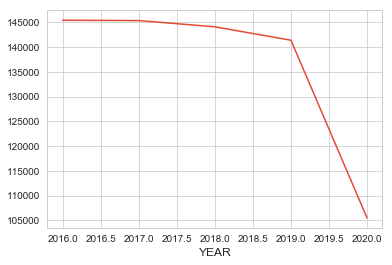

In [356]:
yearly = se_crash.groupby(['YEAR']).size()
yearly_harm = se_crash[se_crash['harm']==True].groupby(['YEAR']).size()
yearly_fatal = se_crash[se_crash['fatal']==True].groupby(['YEAR']).size()

monthly = se_crash.groupby(['MONTH']).size()
monthly_harm = se_crash[se_crash['harm']==True].groupby(['MONTH']).size()
monthly_fatal = se_crash[se_crash['fatal']==True].groupby(['MONTH']).size()

daily = se_crash.groupby(['DAY']).size()
daily_harm = se_crash[se_crash['harm']==True].groupby(['DAY']).size()
daily_fatal = se_crash[se_crash['fatal']==True].groupby(['DAY']).size()

weekdaily = se_crash.groupby(['WEEKDAY']).size()
weekdaily_harm = se_crash[se_crash['harm']==True].groupby(['WEEKDAY']).size()
weekdaily_fatal = se_crash[se_crash['fatal']==True].groupby(['WEEKDAY']).size()

hourly = se_crash.groupby(['HOUR']).size()
hourly_harm = se_crash[se_crash['harm']==True].groupby(['HOUR']).size()
hourly_fatal = se_crash[se_crash['fatal']==True].groupby(['HOUR']).size()

p = sns.lineplot(x = yearly.index, y = yearly.values)
plt.savefig('yearly_acc.png', dpi=300)

Create dummy variables for categorical variables that were not already coded as numeric

In [29]:
se_crash['asphalt'] = se_crash['SURFACE'].apply(lambda x: 1 if x == 'Asphalt' else 0)
se_crash['concrete'] = se_crash['SURFACE'].apply(lambda x: 1 if x == 'Concrete' else 0) 
se_crash['gravel'] = se_crash['SURFACE'].apply(lambda x: 1 if x == 'Gravel' else 0) 
se_crash['brick'] = se_crash['SURFACE'].apply(lambda x: 1 if x == 'Brick' else 0) 

Create dummy variables to account for potential seasonality/time trends

In [287]:
se_crash['weekend'] = se_crash['WEEKDAY'].apply(lambda x: 1 if ((x == 1)|(x==7)) else 0) 
se_crash['06'] = se_crash['HOUR'].apply(lambda x: 1 if ((x >= 0)&(x<=5)) else 0)
se_crash['12'] = se_crash['HOUR'].apply(lambda x: 1 if ((x >= 6)&(x<=11)) else 0)
se_crash['18'] = se_crash['HOUR'].apply(lambda x: 1 if ((x >= 12)&(x<=16)) else 0)
se_crash['24'] = se_crash['HOUR'].apply(lambda x: 1 if ((x >= 17)&(x<=24)) else 0)
se_crash['2016'] = se_crash['YEAR'].apply(lambda x: 1 if x == 2016 else 0)
se_crash['2017'] = se_crash['YEAR'].apply(lambda x: 1 if  x == 2017 else 0)
se_crash['2018'] = se_crash['YEAR'].apply(lambda x: 1 if  x == 2018 else 0)
se_crash['2019'] = se_crash['YEAR'].apply(lambda x: 1 if  x == 2019 else 0)
se_crash['2020'] = se_crash['YEAR'].apply(lambda x: 1 if  x == 2020 else 0)
se_crash['jan'] = se_crash['MONTH'].apply(lambda x: 1 if x == 1 else 0)
se_crash['feb'] = se_crash['MONTH'].apply(lambda x: 1 if  x == 2 else 0)
se_crash['mar'] = se_crash['MONTH'].apply(lambda x: 1 if  x == 3 else 0)
se_crash['apr'] = se_crash['MONTH'].apply(lambda x: 1 if  x == 4 else 0)
se_crash['may'] = se_crash['MONTH'].apply(lambda x: 1 if x == 5 else 0)
se_crash['jun'] = se_crash['MONTH'].apply(lambda x: 1 if  x == 6 else 0)
se_crash['jul'] = se_crash['MONTH'].apply(lambda x: 1 if  x == 7 else 0)
se_crash['aug'] = se_crash['MONTH'].apply(lambda x: 1 if  x == 8 else 0)
se_crash['sep'] = se_crash['MONTH'].apply(lambda x: 1 if x == 9 else 0)
se_crash['oct'] = se_crash['MONTH'].apply(lambda x: 1 if  x == 10 else 0)
se_crash['nov'] = se_crash['MONTH'].apply(lambda x: 1 if  x == 11 else 0)
se_crash['dec'] = se_crash['MONTH'].apply(lambda x: 1 if  x == 12 else 0)

In [260]:
x_columns = ['OCCUPANTS', 'UNITS', 'DEER', 'SCHOOLBUS', 'HITNRUN', 'WEATHER', 'ROADCONDIT', 'ROADLANES', 'SPEEDLIMIT', 'ALCOHOL', 'DRUG',  'COMMERCIAL', 'WORK_ZONE', 
'DISTRACTED', 'ELDERLY', 'DIS_CTRL_I', 'REDLIGHTRU', 'LANEDEPART', 'PEDESTRIAN', 'BICYCLE','MOTORCYCLE', 'CRSHTYPEO', 'YOUNG','LIGHTING','TRAIN','EMERGENCY','HWY_CLSS_C', 
'weekend', '06', '12', '18', '24', '2016', '2017', '2018', '2019', '2020', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'asphalt', 
'concrete', 'gravel', 'brick']
x = se_crash[x_columns]
y = se_crash['harm']
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(x, y)
print(rfe.support_)
print(rfe.ranking_)
x.columns[rfe.support_]

[False  True  True  True  True False False False False  True  True False
 False False False  True False False  True  True  True False False False
 False False False False False  True  True  True  True  True  True  True
 False False False False False False False False False False False False
 False  True  True  True False]
[10  1  1  1  1 32 28 27 31  1  1  4 13  3 14  1 29  7  1  1  1 33 26 34
  9 16 30 18  6  1  1  1  1  1  1  1  2 12  8 17 19 22 23 25 24 21 20 15
 11  1  1  1  5]


Index(['UNITS', 'DEER', 'SCHOOLBUS', 'HITNRUN', 'ALCOHOL', 'DRUG',
       'DIS_CTRL_I', 'PEDESTRIAN', 'BICYCLE', 'MOTORCYCLE', '12', '18', '24',
       '2016', '2017', '2018', '2019', 'asphalt', 'concrete', 'gravel'],
      dtype='object')

In [ ]:
x_columns = ['OCCUPANTS', 'UNITS', 'SCHOOLBUS', 'HITNRUN', 'WEATHER', 'ROADCONDIT', 'ROADLANES', 'SPEEDLIMIT', 'ALCOHOL', 'DRUG',  'COMMERCIAL', 'WORK_ZONE', 
'DISTRACTED', 'ELDERLY', 'DIS_CTRL_I', 'REDLIGHTRU', 'LANEDEPART', 'PEDESTRIAN', 'BICYCLE','MOTORCYCLE', 'CRSHTYPEO', 'YOUNG','LIGHTING','TRAIN','EMERGENCY','HWY_CLSS_C', 
'weekend', '06', '12', '18', '24', '2016', '2017', '2018', '2019', '2020', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'asphalt', 
'concrete', 'gravel', 'brick']
x = se_crash[x_columns]
y = se_crash['harm']
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(x, y)
print(rfe.support_)
print(rfe.ranking_)
x.columns[rfe.support_]

Repeat without the year dummy variables since it listed every year as one of the top 20 which does not help

In [226]:
x_columns = ['OCCUPANTS', 'UNITS', 'DEER', 'SCHOOLBUS', 'HITNRUN', 'WEATHER', 'ROADCONDIT', 'ROADLANES', 'SPEEDLIMIT', 'ALCOHOL', 'DRUG',  'COMMERCIAL', 'WORK_ZONE', 
'DISTRACTED', 'ELDERLY', 'DIS_CTRL_I', 'REDLIGHTRU', 'LANEDEPART', 'PEDESTRIAN', 'BICYCLE','MOTORCYCLE', 'CRSHTYPEO', 'YOUNG','LIGHTING','TRAIN','EMERGENCY','HWY_CLSS_C', 
'weekend', '06', '12', '18', '24', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
x = se_crash[x_columns]
y = se_crash['harm']
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(x, y)
print(rfe.support_)
print(rfe.ranking_)
x.columns[rfe.support_]

[ True  True  True  True  True False False False False  True  True  True
 False  True False  True False  True  True  True  True False False False
 False False False False  True  True  True  True False  True False False
 False False False False False False False  True]
[ 1  1  1  1  1 22 19  8 21  1  1  1  3  1  5  1 23  1  1  1  1 24 16 25
 18  4 20 17  1  1  1  1  2  1  7  9 11 13 15 14 12 10  6  1]


Index(['OCCUPANTS', 'UNITS', 'DEER', 'SCHOOLBUS', 'HITNRUN', 'ALCOHOL', 'DRUG',
       'COMMERCIAL', 'DISTRACTED', 'DIS_CTRL_I', 'LANEDEPART', 'PEDESTRIAN',
       'BICYCLE', 'MOTORCYCLE', '06', '12', '18', '24', 'feb', 'dec'],
      dtype='object')

Also repeat without the hour of day dummy variables since it listed every 6-hour period as one of the top 20 which does not help as much for actionable changes

In [227]:
x_columns = ['OCCUPANTS', 'UNITS', 'DEER', 'SCHOOLBUS', 'HITNRUN', 'WEATHER', 'ROADCONDIT', 'ROADLANES', 'SPEEDLIMIT', 'ALCOHOL', 'DRUG',  'COMMERCIAL', 'WORK_ZONE', 
'DISTRACTED', 'ELDERLY', 'DIS_CTRL_I', 'REDLIGHTRU', 'LANEDEPART', 'PEDESTRIAN', 'BICYCLE','MOTORCYCLE', 'CRSHTYPEO', 'YOUNG','LIGHTING','TRAIN','EMERGENCY','HWY_CLSS_C', 
'weekend', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
x = se_crash[x_columns]
y = se_crash['harm']
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(x, y)
print(rfe.support_)
print(rfe.ranking_)
x.columns[rfe.support_]

[ True  True  True  True  True False False False False  True  True  True
  True  True False  True False  True  True  True  True False False False
 False False False False  True  True  True False False False False False
 False False  True  True]
[ 1  1  1  1  1 19 15 12 17  1  1  1  1  1 10  1 18  1  1  1  1 20 11 21
 14 13 16  9  1  1  1  2  4  6  8  7  5  3  1  1]


Index(['OCCUPANTS', 'UNITS', 'DEER', 'SCHOOLBUS', 'HITNRUN', 'ALCOHOL', 'DRUG',
       'COMMERCIAL', 'WORK_ZONE', 'DISTRACTED', 'DIS_CTRL_I', 'LANEDEPART',
       'PEDESTRIAN', 'BICYCLE', 'MOTORCYCLE', 'jan', 'feb', 'mar', 'nov',
       'dec'],
      dtype='object')

In [261]:
x_columns = ['UNITS', 'DEER', 'SCHOOLBUS', 'HITNRUN', 'ALCOHOL', 'DRUG',
       'DIS_CTRL_I', 'PEDESTRIAN', 'BICYCLE', 'MOTORCYCLE', '12', '18', '24',
       '2016', '2017', '2018', '2019', 'asphalt', 'concrete', 'gravel']
x = se_crash[x_columns]
y = se_crash['harm']

result = sm.Logit(y,x).fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.474544
         Iterations 7
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.067      
Dependent Variable: harm             AIC:              647098.3658
Date:               2022-04-07 10:08 BIC:              647327.0148
No. Observations:   681769           Log-Likelihood:   -3.2353e+05
Df Model:           19               LL-Null:          -3.4687e+05
Df Residuals:       681749           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     7.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
UNITS          0.0861    0.0052   16.5899  0.0000   0.0760   0.0963
DEER          -2.2453    0.0331  -67.9302  0.0000

In [228]:
x_columns = ['OCCUPANTS', 'UNITS', 'DEER', 'SCHOOLBUS', 'HITNRUN', 'ALCOHOL', 'DRUG',
       'COMMERCIAL', 'WORK_ZONE', 'DISTRACTED', 'DIS_CTRL_I', 'LANEDEPART',
       'PEDESTRIAN', 'BICYCLE', 'MOTORCYCLE', 'jan', 'feb', 'mar', 'nov', 'dec']
x = se_crash[x_columns]
y = se_crash['harm']

result = sm.Logit(y,x).fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.483450
         Iterations 7
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.050      
Dependent Variable: harm             AIC:              659242.7032
Date:               2022-04-06 22:01 BIC:              659471.3521
No. Observations:   681769           Log-Likelihood:   -3.2960e+05
Df Model:           19               LL-Null:          -3.4687e+05
Df Residuals:       681749           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     7.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
OCCUPANTS     0.1161    0.0023    49.5070  0.0000   0.1115   0.1207
UNITS        -0.7022    0.0037  -191.0759  0.0000

Proceed as all p-values are over .05

In [384]:
def log_reg_func(x_cols, y_col, weighting):
    x = se_crash[x_cols]
    y = se_crash[y_col]

    #80:20 training:test split
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

    logreg = LogisticRegression(class_weight=weighting)
    result = logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)

    auc = roc_auc_score(y_test, y_pred)
    recall = recall_score(y_test,y_pred)
    
    #accuracy score of the model
    print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
    print('Test accuracy = ', accuracy_score(y_test, y_pred))
    print('Area Under Curve: ' + str(auc))
    print('Recall score: ' + str(recall))
    print('F1 Score: ' + str(f1_score(y_test, y_pred)))
    #Log of the odds of having the outcome
    print(logreg.intercept_)

    coefficients = {}
    prob = {}
    for c in range(len(x_cols)):
        coefficients[x_cols[c]] = logreg.coef_[0][c]
        prob[x_cols[c]] = np.exp(logreg.coef_[0][c])/(1 + np.exp(logreg.coef_[0][c]))
    print(coefficients)
    print(prob)

    cm = metrics.confusion_matrix(y_test, y_pred)
    get_stats(se_crash, x_columns, y)
    output_confusion_matrix(cm)

Accuracy of logistic regression classifier on test set: 0.81
Test accuracy =  0.809143846165129
Area Under Curve: 0.5567353909063475
Recall score: 0.12627659574468086
F1 Score: 0.2148675556628251
[-2.33374107]
{'OCCUPANTS': 0.13954458845645884, 'UNITS': 0.3037981642928516, 'DEER': -1.5061186218143943, 'SCHOOLBUS': -1.7825380778534468, 'HITNRUN': -0.5959882477463108, 'ALCOHOL': 0.9923070897062413, 'DRUG': 1.1815300140030867, 'COMMERCIAL': -0.22563553254485408, 'WORK_ZONE': -0.120861414654313, 'DISTRACTED': 0.25524541256824124, 'DIS_CTRL_I': 1.0415522381214801, 'LANEDEPART': 0.2058612545713773, 'PEDESTRIAN': 3.5473677464777813, 'BICYCLE': 2.8070300295249733, 'MOTORCYCLE': 2.6688569481751827, 'jan': -0.15817599531626558, 'feb': -0.1898766416911517, 'mar': -0.07205570076386938, 'nov': -0.10373482349549172, 'dec': -0.15729331568482796}
                            OLS Regression Results                            
Dep. Variable:                   harm   R-squared:                 -100289.985

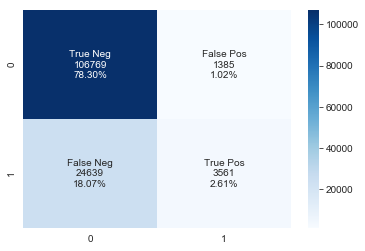

In [378]:
x_columns = ['OCCUPANTS', 'UNITS', 'DEER', 'SCHOOLBUS', 'HITNRUN', 'ALCOHOL', 'DRUG',
       'COMMERCIAL', 'WORK_ZONE', 'DISTRACTED', 'DIS_CTRL_I', 'LANEDEPART',
       'PEDESTRIAN', 'BICYCLE', 'MOTORCYCLE', 'jan', 'feb', 'mar', 'nov', 'dec']
y = 'harm'
log_reg_func(x_columns, y, None)

Balanced class weight for low frequency outcomes of True/1 for harm due to the clearly disproportionate distribtuon of the two

Accuracy of logistic regression classifier on test set: 0.70
Test accuracy =  0.6974199510098714
Area Under Curve: 0.6399143485576189
Recall score: 0.5418439716312057
F1 Score: 0.4255200646077585
[-0.98701051]
{'OCCUPANTS': 0.24027964302498747, 'UNITS': 0.17151413272322535, 'DEER': -1.53888234312445, 'SCHOOLBUS': -1.4489883001538, 'HITNRUN': -0.5052306203905926, 'ALCOHOL': 1.001664896590658, 'DRUG': 1.2144266104742858, 'COMMERCIAL': -0.22632565041109712, 'WORK_ZONE': -0.12492689383335769, 'DISTRACTED': 0.2604831888130377, 'DIS_CTRL_I': 1.0336777223140992, 'LANEDEPART': 0.24149731257983434, 'PEDESTRIAN': 3.699407669875028, 'BICYCLE': 2.8644275928030183, 'MOTORCYCLE': 2.7218421032735134, 'jan': -0.16207480758377124, 'feb': -0.19126317777223234, 'mar': -0.073386913598988, 'nov': -0.0961285828717275, 'dec': -0.15717355650183948}
                            OLS Regression Results                            
Dep. Variable:                   harm   R-squared:                 -100289.985
Model

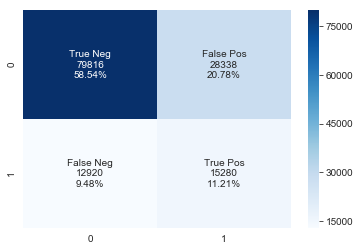

In [379]:
x_columns = ['OCCUPANTS', 'UNITS', 'DEER', 'SCHOOLBUS', 'HITNRUN', 'ALCOHOL', 'DRUG',
       'COMMERCIAL', 'WORK_ZONE', 'DISTRACTED', 'DIS_CTRL_I', 'LANEDEPART',
       'PEDESTRIAN', 'BICYCLE', 'MOTORCYCLE', 'jan', 'feb', 'mar', 'nov', 'dec']
y = 'harm'
log_reg_func(x_columns, y, 'balanced')

Balancing the class weights above for the minority class significantly helped the recall for a slight sacrifice in accuracy

In [237]:
x_cols = ['OCCUPANTS', 'UNITS', 'DEER', 'SCHOOLBUS', 'HITNRUN', 'ALCOHOL', 'DRUG',
       'COMMERCIAL', 'WORK_ZONE', 'DISTRACTED', 'DIS_CTRL_I', 'LANEDEPART',
       'PEDESTRIAN', 'BICYCLE', 'MOTORCYCLE', 'jan', 'feb', 'mar', 'nov', 'dec']
x = se_crash[x_cols]
y = se_crash['harm']

#80:20 training:test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

Use a grid search to find the optimal class weights to better represent the minority class (crashes involving harm)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  4.1min finished


Text(0.5, 1.0, 'Scoring for different class weights')

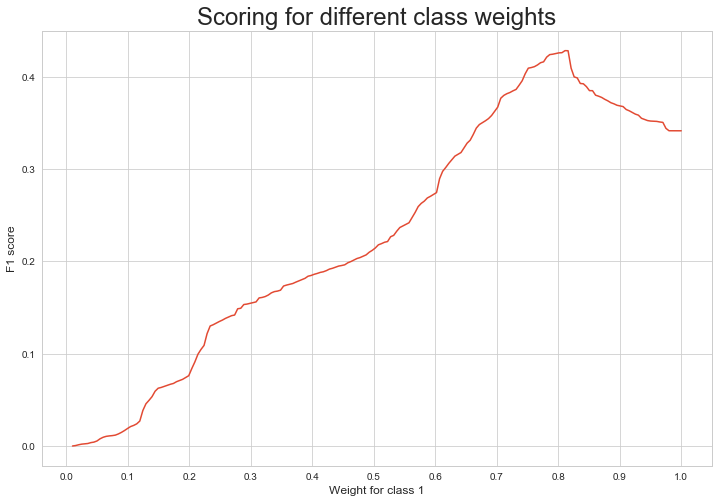

In [238]:
#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

lr = LogisticRegression(class_weight="balanced")

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

In [239]:
weigh_data[weigh_data['score']==max(weigh_data['score'])]

,score,weight
38,0.428377,0.810955


Accuracy of logistic regression classifier on test set: 0.67
Test accuracy =  0.6661337401176349
Area Under Curve: 0.6455816184487132
Recall score: 0.610531914893617
F1 Score: 0.4306510918232072
[-1.07764546]
{'OCCUPANTS': 0.2806978922389247, 'DEER': -1.7433112250834621, 'SCHOOLBUS': -1.423570235295474, 'HITNRUN': -0.4505614365833265, 'ALCOHOL': 0.8803545740117144, 'DRUG': 1.2046847452402432, 'COMMERCIAL': -0.21699919417831887, 'WORK_ZONE': -0.10382088224311353, 'DISTRACTED': 0.28610989160687, 'DIS_CTRL_I': 1.0338707746856544, 'LANEDEPART': 0.19689316995503955, 'PEDESTRIAN': 3.764729455189737, 'BICYCLE': 2.9432648415551617, 'MOTORCYCLE': 2.727758686693513, '06': 0.3738334323309255, 'jul': 0.10132402626520073, 'asphalt': 0.3944434770452441, 'concrete': 0.3372788695570805, 'gravel': 0.3747415750608325}
{'OCCUPANTS': 0.5697173132085418, 'DEER': 0.14889283561997918, 'SCHOOLBUS': 0.19410249340779112, 'HITNRUN': 0.38922728776743537, 'ALCOHOL': 0.7068956921515942, 'DRUG': 0.7693571250499636, 

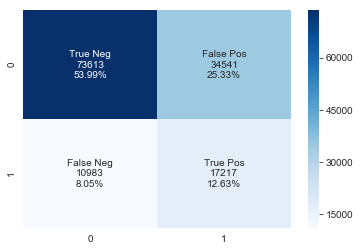

In [385]:
x_columns = ['OCCUPANTS', 'DEER', 'SCHOOLBUS', 'HITNRUN', 'ALCOHOL', 'DRUG',
       'COMMERCIAL', 'WORK_ZONE', 'DISTRACTED', 'DIS_CTRL_I', 'LANEDEPART',
       'PEDESTRIAN', 'BICYCLE', 'MOTORCYCLE', '06', 'jul', 'asphalt','concrete', 'gravel']
y = 'harm'
log_reg_func(x_columns, y, {0: 0.189045, 1: 0.810955})

In [189]:
x_columns = ['DEER', 'HITNRUN', 'ALCOHOL', 'DRUG', 'DIS_CTRL_I', 'PEDESTRIAN',
       'BICYCLE', 'MOTORCYCLE']
x = se_crash[x_columns]
y = se_crash['harm']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
logistic_regression = sm.Logit(y_train, X_train).fit()
print(logistic_regression.summary())

yhat = logistic_regression.predict(X_test)
prediction = list(map(round, yhat))

cm = confusion_matrix(y_test, prediction)

auc = roc_auc_score(y_test, y_pred)
recall = recall_score(y_test,y_pred)
 
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, prediction))
print(f'Area Under Curve: ' + str(auc))
print(f'Recall score: ' + str(recall))

Optimization terminated successfully.
         Current function value: 0.616207
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   harm   No. Observations:               545415
Model:                          Logit   Df Residuals:                   545407
Method:                           MLE   Df Model:                            7
Date:                Wed, 06 Apr 2022   Pseudo R-squ.:                 -0.2117
Time:                        08:47:14   Log-Likelihood:            -3.3609e+05
converged:                       True   LL-Null:                   -2.7737e+05
                                        LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
DEER          -3.3778      0.036    -93.678      0.000      -3.448      -3.307
HITNRUN       -1.9013      0.

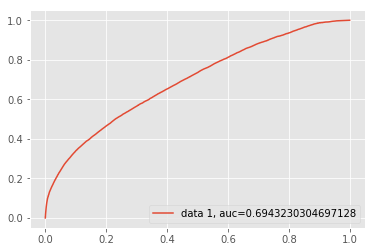

In [132]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 14.3min finished


Text(0.5, 1.0, 'Scoring for different class weights')

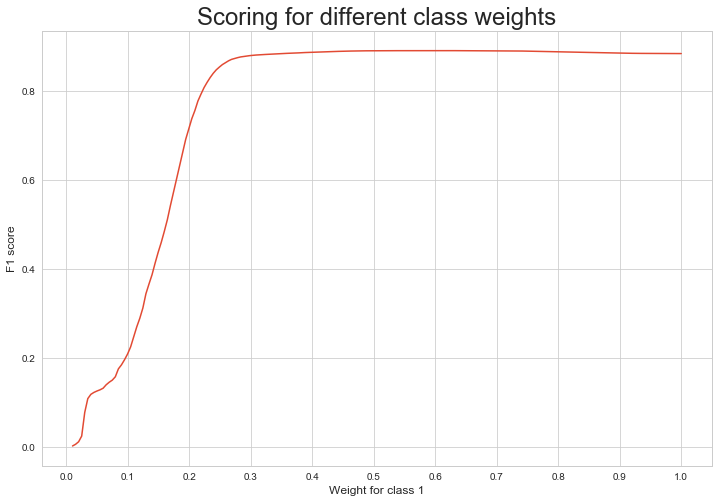

In [54]:
#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

lr = LogisticRegression(class_weight="balanced")

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

In [57]:
weigh_data[weigh_data['score']==max(weigh_data['score'])]

,score,weight
80,0.891631,0.60201


The f1 score for the testing data: 0.8919205913340688


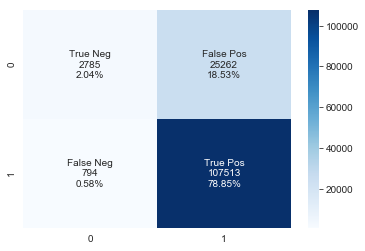

In [58]:
lr = LogisticRegression(solver='newton-cg', class_weight={0: 0.39799, 1: 0.60201})
lr.fit(X_train, y_train)

# Predicting on the test data
pred_test = lr.predict(X_test)

#Calculating and printing the f1 score 
f1_test = f1_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)

#Ploting the confusion matrix
cm = metrics.confusion_matrix(y_test, pred_test)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

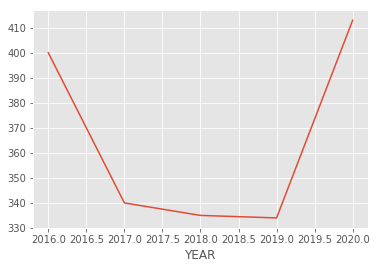

In [123]:
yearly_fatal = se_crash[se_crash['fatal']==True].groupby(['YEAR']).size()
plt = sns.lineplot(x = yearly_fatal.index, y = yearly_fatal.values)
# yearly_fatal
# plt.set_xticks(range(len(yearly_fatal)))
# plt.set_xticklabels(['2016','2017','2018', '2019', '2020'])

Checking the monthly data of 2020 vs other years to see if the data was extremely skewed by COVID-19 mandated lockdowns, 

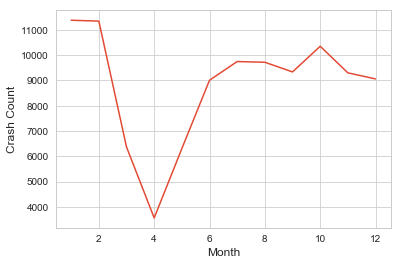

In [388]:
monthly_20 = se_crash[se_crash['YEAR']== 2020].groupby(['MONTH']).size()
p = sns.lineplot(x = monthly_20.index, y = monthly_20.values)
p.set_ylabel('Crash Count')
p.set_xlabel('Month')
plt.savefig('2020_month.png', dpi=300)

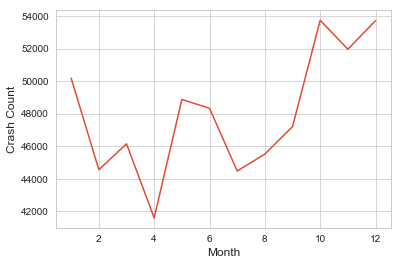

In [389]:
monthly_no_20 = se_crash[se_crash['YEAR']!= 2020].groupby(['MONTH']).size()
p = sns.lineplot(x = monthly_no_20.index, y = monthly_no_20.values)
p.set_ylabel('Crash Count')
p.set_xlabel('Month')
plt.savefig('2016-2019_month.png', dpi=300)

AttributeError: 'AxesSubplot' object has no attribute 'savefig'

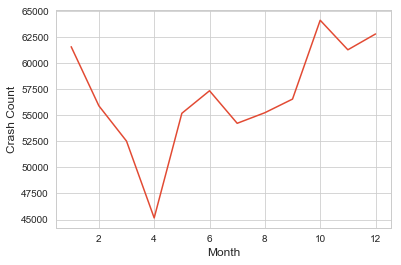

In [500]:
yearly = se_crash.groupby(['YEAR']).size()
yearly_harm = se_crash[se_crash['harm']==True].groupby(['YEAR']).size()
yearly_fatal = se_crash[se_crash['fatal']==True].groupby(['YEAR']).size()

monthly = se_crash.groupby(['MONTH']).size()
monthly_harm = se_crash[se_crash['harm']==True].groupby(['MONTH']).size()
monthly_fatal = se_crash[se_crash['fatal']==True].groupby(['MONTH']).size()

daily = se_crash.groupby(['DAY']).size()
daily_harm = se_crash[se_crash['harm']==True].groupby(['DAY']).size()
daily_fatal = se_crash[se_crash['fatal']==True].groupby(['DAY']).size()

weekdaily = se_crash.groupby(['WEEKDAY']).size()
weekdaily_harm = se_crash[se_crash['harm']==True].groupby(['WEEKDAY']).size()
weekdaily_fatal = se_crash[se_crash['fatal']==True].groupby(['WEEKDAY']).size()

hourly = se_crash.groupby(['HOUR']).size()
hourly_harm = se_crash[se_crash['harm']==True].groupby(['HOUR']).size()
hourly_fatal = se_crash[se_crash['fatal']==True].groupby(['HOUR']).size()

# plot the result to check seasonality
# sns.lineplot(x = yearly.index, y = yearly.values)
# sns.lineplot(x = monthly.index, y = monthly.values)
# sns.lineplot(x = daily.index, y = daily.values)
p = sns.lineplot(x = monthly.index, y = monthly.values)
p.set_ylabel('Crash Count')
p.set_xlabel('Month')
plt.savefig('monthly.png', dpi=300)
# sns.lineplot(x = hourly.index, y = hourly.values)

# for i in crash_timing:
#     pd.crosstab(se_crash[i],se_crash['CRASHID'])[1].plot(kind='line')
    # plt.figure(figsize=(10, 2), dpi=100)
    # ax = sns.lineplot(x=se_crash_[i], y='Vehicles', data=se_crash)
    # plt.legend(bbox_to_anchor = (1.05, 1), loc=2, borderaxespad=0.)

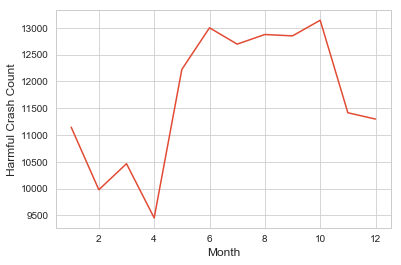

In [390]:
p = sns.lineplot(x = monthly_harm.index, y = monthly_harm.values)
p.set_ylabel('Harmful Crash Count')
p.set_xlabel('Month')
plt.savefig('monthly_harm.png', dpi=300)

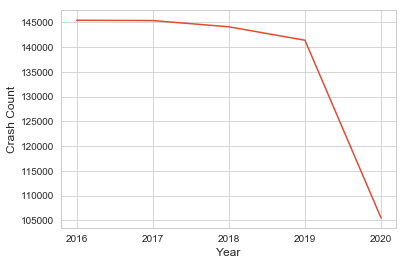

In [501]:
p = sns.lineplot(x = yearly.index, y = yearly.values)
p.set_xticks(yearly.index)
p.set_xticklabels(yearly.index)
p.set_ylabel('Crash Count')
p.set_xlabel('Year')
p.get_figure().savefig('yearly.png', dpi=300, bbox_inches="tight")

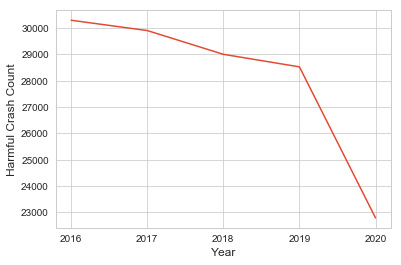

In [392]:
p = sns.lineplot(x = yearly_harm.index, y = yearly_harm.values)
p.set_xticks(yearly_harm.index)
p.set_xticklabels(yearly_harm.index)
p.set_ylabel('Harmful Crash Count')
p.set_xlabel('Year')
plt.savefig('yearly_harm.png', dpi=300)

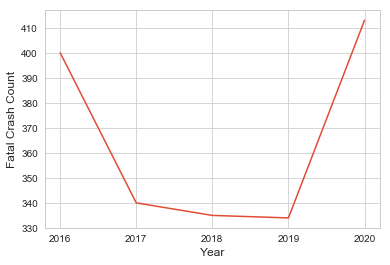

In [393]:
p = sns.lineplot(x = yearly_fatal.index, y = yearly_fatal.values)
p.set_xticks(yearly_fatal.index)
p.set_xticklabels(yearly_fatal.index)
p.set_ylabel('Fatal Crash Count')
p.set_xlabel('Year')
plt.savefig('yearly_fatal.png', dpi=300)

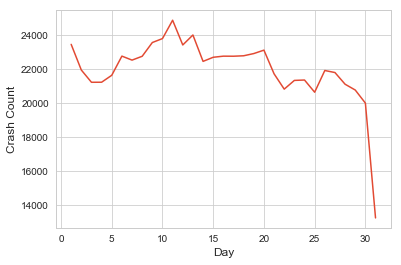

In [394]:
p = sns.lineplot(x = daily.index, y = daily.values)
p.set_ylabel('Crash Count')
p.set_xlabel('Day')
plt.savefig('daily.png', dpi=300)

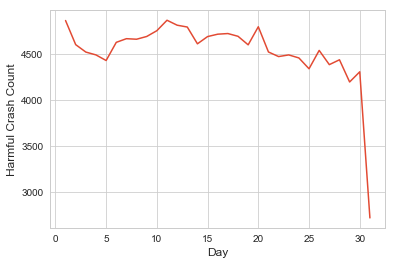

In [395]:
p = sns.lineplot(x = daily_harm.index, y = daily_harm.values)
p.set_ylabel('Harmful Crash Count')
p.set_xlabel('Day')
plt.savefig('daily_harm.png', dpi=300)

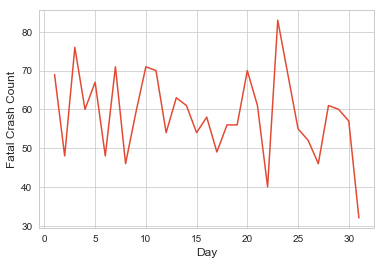

In [396]:
p = sns.lineplot(x = daily_fatal.index, y = daily_fatal.values)
p.set_ylabel('Fatal Crash Count')
p.set_xlabel('Day')
plt.savefig('daily_fatal.png', dpi=300)

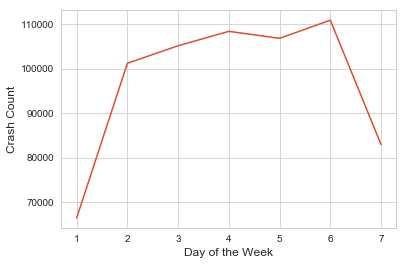

In [502]:
p = sns.lineplot(x = weekdaily.index, y = weekdaily.values)
p.set_ylabel('Crash Count')
p.set_xlabel('Day of the Week')
p.get_figure().savefig('weekdaily.png', dpi=300, bbox_inches="tight")

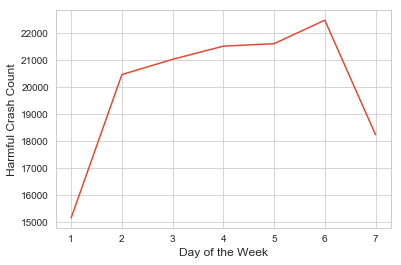

In [398]:
p = sns.lineplot(x = weekdaily_harm.index, y = weekdaily_harm.values)
p.set_ylabel('Harmful Crash Count')
p.set_xlabel('Day of the Week')
plt.savefig('weekdaily_harm.png', dpi=300)

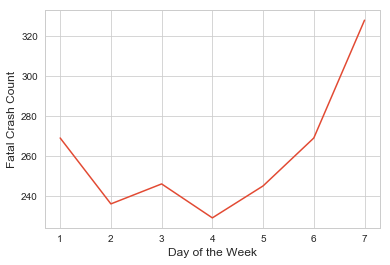

In [399]:
p = sns.lineplot(x = weekdaily_fatal.index, y = weekdaily_fatal.values)
p.set_ylabel('Fatal Crash Count')
p.set_xlabel('Day of the Week')
plt.savefig('weekdaily_fatal.png', dpi=300)

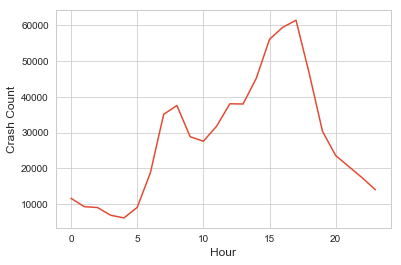

In [400]:
p = sns.lineplot(x = hourly.index, y = hourly.values)
p.set_ylabel('Crash Count')
p.set_xlabel('Hour')
plt.savefig('hourly.png', dpi=300)

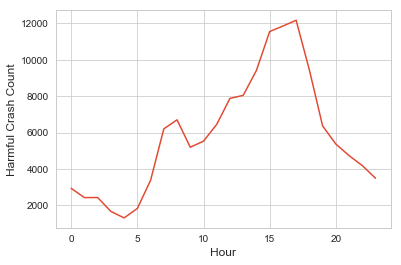

In [401]:
p = sns.lineplot(x = hourly_harm.index, y = hourly_harm.values)
p.set_ylabel('Harmful Crash Count')
p.set_xlabel('Hour')
plt.savefig('hourly_harm.png', dpi=300)

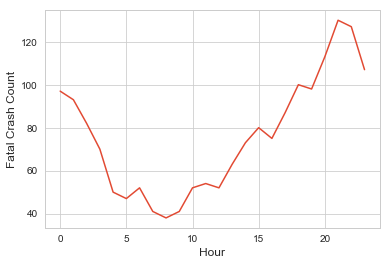

In [402]:
p = sns.lineplot(x = hourly_fatal.index, y = hourly_fatal.values)
p.set_ylabel('Fatal Crash Count')
p.set_xlabel('Hour')
plt.savefig('hourly_fatal.png', dpi=300)

In [307]:
inj_only = se_crash[se_crash['harm']==True]

In [149]:
inj_only['fatal'].value_counts()

False    138707
True       1822
Name: fatal, dtype: int64

In [320]:
inj_only.shape

(140529, 88)

In [308]:
x_columns = ['OCCUPANTS', 'UNITS', 'SCHOOLBUS', 'HITNRUN', 'WEATHER', 'ROADCONDIT', 'ROADLANES', 'SPEEDLIMIT', 'ALCOHOL', 'DRUG',  'COMMERCIAL', 'WORK_ZONE', 
'DISTRACTED', 'ELDERLY', 'DIS_CTRL_I', 'REDLIGHTRU', 'LANEDEPART', 'PEDESTRIAN', 'BICYCLE','MOTORCYCLE', 'CRSHTYPEO', 'YOUNG','LIGHTING','TRAIN','EMERGENCY','HWY_CLSS_C', 
'weekend', '06', '12', '18', '24', '2016', '2017', '2018', '2019', '2020', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'asphalt', 
'concrete', 'gravel', 'brick']
x = inj_only[x_columns]
y = inj_only['fatal']
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(x, y)
print(rfe.support_)
print(rfe.ranking_)
x.columns[rfe.support_]

[False False  True False False False False False  True  True  True False
 False  True  True False  True  True  True  True False False False  True
  True False False False  True  True  True  True  True  True  True  True
 False False False False False False False False False False False False
 False False False False]
[25 24  1  3 33 31 29 26  1  1  1 22  2  1  1  8  1  1  1  1 32 23 30  1
  1 27 21  4  1  1  1  1  1  1  1  1  9 16 10 20 11 17 12 18 14 15 19 13
  6  7  5 28]


Index(['SCHOOLBUS', 'ALCOHOL', 'DRUG', 'COMMERCIAL', 'ELDERLY', 'DIS_CTRL_I',
       'LANEDEPART', 'PEDESTRIAN', 'BICYCLE', 'MOTORCYCLE', 'TRAIN',
       'EMERGENCY', '12', '18', '24', '2016', '2017', '2018', '2019', '2020'],
      dtype='object')

In [316]:
def log_fat_func(x_cols, y_col, weighting):
    x = inj_only[x_cols]
    y = inj_only[y_col]

    #80:20 training:test split
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

    logreg = LogisticRegression(class_weight=weighting)
    result = logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)

    auc = roc_auc_score(y_test, y_pred)
    recall = recall_score(y_test,y_pred)
    
    #accuracy score of the model
    print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
    print('Test accuracy = ', accuracy_score(y_test, y_pred))
    print('Area Under Curve: ' + str(auc))
    print('Recall score: ' + str(recall))
    print('F1 Score: ' + str(f1_score(y_test, y_pred)))
    #Log of the odds of having the outcome
    print(logreg.intercept_)

    cm = metrics.confusion_matrix(y_test, y_pred)
    get_stats(inj_only, x_columns, y)
    output_confusion_matrix(cm)

Accuracy of logistic regression classifier on test set: 0.82
Test accuracy =  0.8204298014658792
Area Under Curve: 0.7668015451644159
Recall score: 0.7118155619596542
F1 Score: 0.08915358238585094
[-0.67400533]
                            OLS Regression Results                            
Dep. Variable:                  fatal   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     407.4
Date:                Sat, 09 Apr 2022   Prob (F-statistic):               0.00
Time:                        15:20:40   Log-Likelihood:             1.1062e+05
No. Observations:              140529   AIC:                        -2.212e+05
Df Residuals:                  140509   BIC:                        -2.210e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         

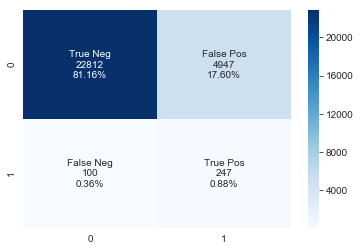

In [318]:
x_columns = ['SCHOOLBUS', 'ALCOHOL', 'DRUG', 'COMMERCIAL', 'ELDERLY', 'DIS_CTRL_I',
       'LANEDEPART', 'PEDESTRIAN', 'BICYCLE', 'MOTORCYCLE', 'TRAIN',
       'EMERGENCY', '12', '18', '24', '2016', '2017', '2018', '2019', '2020']
log_fat_func(x_columns, 'fatal', 'balanced')

Accuracy of logistic regression classifier on test set: 0.82
Test accuracy =  0.8209279157475272
Area Under Curve: 0.7656308056176812
Recall score: 0.7089337175792507
F1 Score: 0.0890497737556561
[-0.6744594]
                            OLS Regression Results                            
Dep. Variable:                  fatal   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     429.8
Date:                Sat, 09 Apr 2022   Prob (F-statistic):               0.00
Time:                        15:21:53   Log-Likelihood:             1.1061e+05
No. Observations:              140529   AIC:                        -2.212e+05
Df Residuals:                  140510   BIC:                        -2.210e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
 

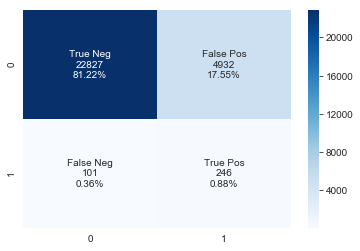

In [319]:
x_columns = ['SCHOOLBUS', 'ALCOHOL', 'DRUG', 'COMMERCIAL', 'ELDERLY', 'DIS_CTRL_I',
       'LANEDEPART', 'PEDESTRIAN', 'BICYCLE', 'MOTORCYCLE', 'TRAIN','12', '18', '24',
       '2016', '2017', '2018', '2019', '2020']
log_fat_func(x_columns, 'fatal', 'balanced')

In [314]:
x_cols = ['SCHOOLBUS', 'ALCOHOL', 'DRUG', 'COMMERCIAL', 'ELDERLY', 'DIS_CTRL_I',
       'LANEDEPART', 'PEDESTRIAN', 'BICYCLE', 'MOTORCYCLE', 'TRAIN',
       'EMERGENCY', '12', '18', '24', '2016', '2017', '2018', '2019', '2020']
x = inj_only[x_cols]
y = inj_only['fatal']

#80:20 training:test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   44.5s finished


Text(0.5, 1.0, 'Scoring for different class weights')

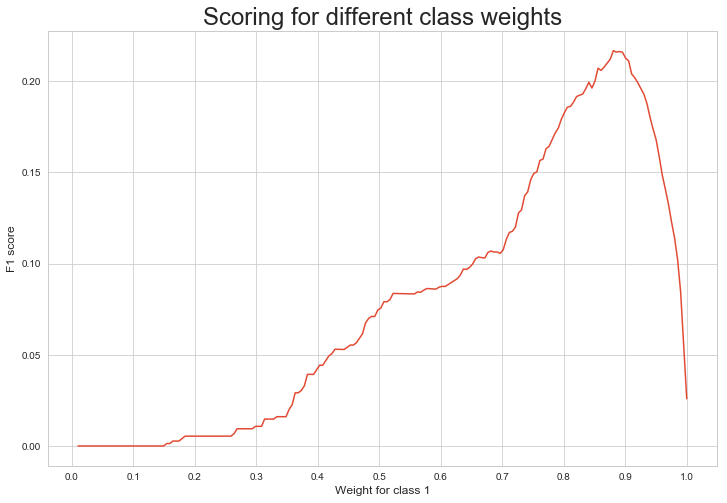

In [315]:
#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

lr = LogisticRegression(class_weight="balanced")

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

In [321]:
weigh_data[weigh_data['score']==max(weigh_data['score'])]

,score,weight
24,0.216685,0.880603


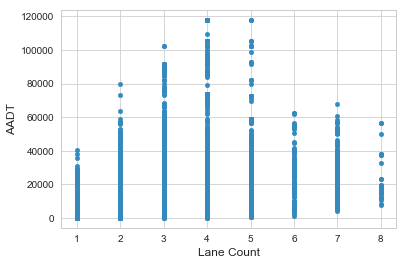

In [354]:
p = se_traff.plot.scatter(x='NUMBER_LAN',y='AADT')
p.set_xlabel('Lane Count')
plt.savefig('aadt by lanes.png', dpi=300)

In [ ]:
Index(['FID', 'AADT', 'AADTR', 'AADTTYPE', 'AADTYEAR', 'BMP', 'CNTNAME',
       'CNTNUM', 'CNTNAME2', 'CNTNUM2', 'COMMUNITY', 'COMMUNITY2',
       'COMMUNITY3', 'COMMUNITY4', 'EMP', 'FALINK_ID', 'INTRP_AADT',
       'JURISDICTI', 'MMP', 'NFCNAME', 'NFCNUM', 'NUMBER_LAN', 'POSTED_SPE',
       'PR', 'SEG_LENGTH', 'SEM_ID_1', 'SEM_ID_2', 'SEM_ID_3', 'SEM_ID_4',
       'SEMMCD1', 'SEMMCD2', 'SEMMCD3', 'SEMMCD4', 'SPEED_SOUR', 'VMT',
       'ROAD_NAME', 'TEXT_AADT', 'TEXT_YEAR', 'PASER', 'COND', 'SURFACE',
       'LANES', 'LANEMI', 'MPO_ID_CAR', 'LATEST_COU', 'AGENCY_ID', 'AADT_MS2',
       'AADT_MS2_Y', 'MDOT_ID', 'GlobalID', 'SHAPE_Length'],
      dtype='object')

In [299]:
se_traff['cond_num'] = 0
se_traff.loc[se_traff['COND']=='Poor', 'cond_num'] = 1
se_traff.loc[se_traff['COND']=='Fair', 'cond_num'] = 2
se_traff.loc[se_traff['COND']=='Good', 'cond_num'] = 3

In [83]:
def get_lin_stats(x, y):
    results = sm.OLS(y, x).fit()
    print(results.summary())

In [331]:
traff_x_cols = ['BMP', 'CNTNUM', 'EMP', 'MMP', 'NFCNUM', 'NUMBER_LAN', 'POSTED_SPE', 'SEG_LENGTH', 'PASER', 'LANES', 'LANEMI','cond_num']
X_traff = se_traff[traff_x_cols]
y_traff = se_traff['AADT']
X_train_traff, X_test_traff, y_train_traff, y_test_traff = train_test_split(X_traff, y_traff, test_size=0.2, random_state=1)
reg = LinearRegression().fit(X_train_traff, y_train_traff)
yhat_traff = reg.predict(X_test_traff)
# evaluate predictions
mae = mean_absolute_error(y_test_traff, yhat_traff)
print('Score: ' + str(reg.score(X_traff, y_traff)))
print('R2 Score: ' + str(r2_score(y_test_traff, yhat_traff)))
print('Coff: ' + str(reg.coef_))
print('Intercept: ' + str(reg.intercept_))
print('MAE: %.3f' % mae)
rmse = mean_squared_error(y_test_traff, yhat_traff)
r2 = r2_score(y_test_traff, yhat_traff)

# printing values
print('Slope:' ,reg.coef_)
print('Intercept:', reg.intercept_)
print('Root mean squared error: ', rmse)

Score: 0.5067322698247951
R2 Score: 0.5092677175554843
Coff: [  694.2865044    -63.88963844  -472.94322416   110.67164012
 -4180.90445525  9093.10290911   223.70297378 -1167.22972855
   528.40097343 -4893.65640696   656.9762714   -923.13004398]
Intercept: 14741.01716437006
MAE: 6893.791
Slope: [  694.2865044    -63.88963844  -472.94322416   110.67164012
 -4180.90445525  9093.10290911   223.70297378 -1167.22972855
   528.40097343 -4893.65640696   656.9762714   -923.13004398]
Intercept: 14741.01716437006
Root mean squared error:  111935283.58849956


In [330]:
get_lin_stats(y_test_traff, yhat_traff)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                 1.071e+04
Date:                Sat, 09 Apr 2022   Prob (F-statistic):               0.00
Time:                        18:37:55   Log-Likelihood:                -40542.
No. Observations:                3850   AIC:                         8.109e+04
Df Residuals:                    3849   BIC:                         8.109e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AADT           0.7342      0.007    103.471      0.0

In [303]:
# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select a subset of features
	fs = SelectKBest(score_func=f_regression, k=8)

	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)

	features = X_train.columns[fs.get_support()]
	# mask = fs.get_support()
	# new_features = fs.columns[mask]
	print(features)

	return X_train_fs, X_test_fs, fs

In [304]:
X_train_fs, X_test_fs, fs = select_features(X_train_traff, y_train_traff, X_test_traff)
# fit the model
model = LinearRegression()
model.fit(X_train_fs, y_train_traff)
# evaluate the model
yhat = model.predict(X_test_fs)
# evaluate predictions
mae = mean_absolute_error(y_test_traff, yhat_traff)
print('MAE: %.3f' % mae)
importance = model.coef_
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))

Index(['BMP', 'EMP', 'MMP', 'NFCNUM', 'NUMBER_LAN', 'POSTED_SPE', 'PASER',
       'LANES'],
      dtype='object')
MAE: 6893.791


In [305]:
traff_x_cols = ['BMP', 'EMP', 'MMP', 'NFCNUM', 'NUMBER_LAN', 'POSTED_SPE', 'PASER', 'LANES']
X_traff = se_traff[traff_x_cols]
y_traff = se_traff['AADT']
X_train_traff, X_test_traff, y_train_traff, y_test_traff = train_test_split(X_traff, y_traff, test_size=0.2, random_state=1)
reg = LinearRegression().fit(X_train_traff, y_train_traff)
yhat_traff = reg.predict(X_test_traff)
# evaluate predictions
mae = mean_absolute_error(y_test_traff, yhat_traff)
print('Score: ' + str(reg.score(X_traff, y_traff)))
print('R2 Score: ' + str(r2_score(y_test_traff, yhat_traff)))
print('Coff: ' + str(reg.coef_))
print('Intercept: ' + str(reg.intercept_))
print('MAE: %.3f' % mae)
rmse = mean_squared_error(y_test_traff, yhat_traff)
r2 = r2_score(y_test_traff, yhat_traff)

# printing values
print('Slope:' ,reg.coef_)
print('Intercept:', reg.intercept_)
print('Root mean squared error: ', rmse)

Score: 0.4958461366708173
R2 Score: 0.4984677539733958
Coff: [ 1254.47860971 -1036.27819452   109.1002076  -4139.63838477
  9649.87648534   237.02360494   260.19496199 -5412.19957503]
Intercept: 4556.500447852006
MAE: 6972.347
Slope: [ 1254.47860971 -1036.27819452   109.1002076  -4139.63838477
  9649.87648534   237.02360494   260.19496199 -5412.19957503]
Intercept: 4556.500447852006
Root mean squared error:  114398738.77486835


In [96]:
get_lin_stats(X_train_traff2, y_train_traff)

                            OLS Regression Results                            
Dep. Variable:                   AADT   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     4373.
Date:                Sat, 02 Apr 2022   Prob (F-statistic):               0.00
Time:                        12:14:43   Log-Likelihood:            -1.6490e+05
No. Observations:               15396   AIC:                         3.298e+05
Df Residuals:                   15387   BIC:                         3.299e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
BMP         1627.8491    178.165      9.137      0.0

In [192]:
se_traff['AADT'].corr(se_traff['VMT'])

0.4233091608219773

Transform the crash data to get annual counts by road segment. This will be used to compare the correlation of traffic volume to crash counts

In [54]:
crash_counts = se_crash.groupby(['FALINK_ID','YEAR'])['CRASHID'].count().reset_index()

In [55]:
crash_counts.head(10)

,FALINK_ID,YEAR,CRASHID
0,0,2016,21447
1,0,2017,21292
2,0,2018,21153
3,0,2019,21072
4,0,2020,19099
5,1,2016,1
6,1,2020,1
7,3,2016,4
8,3,2017,3
9,3,2019,2


Ensure that the crash FALINK_ID: traffic FALINK_ID relationship is many:1 and not many:many

In [61]:
se_traff_trim = se_traff[['FALINK_ID','AADTYEAR', 'AADT', 'VMT']]

In [63]:
linked = se_traff_trim.merge(crash_counts, left_on=['FALINK_ID', 'AADTYEAR'], right_on=['FALINK_ID','YEAR'], how="left")

In [65]:
linked = linked.loc[linked['FALINK_ID']!=0]

In [508]:
linked.head(10)

,FALINK_ID,AADTYEAR,AADT,VMT,YEAR,CRASHID
0,1009,2017,19013,21883.963,2017.0,25.0
1,1107,2017,42518,17287.956,2017.0,10.0
2,22,2015,17822,15662.130,NaN,NaN
3,817,2018,10131,1918.400,2018.0,3.0
4,976,2018,32609,4484.724,2018.0,1.0
5,465,2019,20126,15346.800,2019.0,33.0
6,262,2013,2522,3644.900,NaN,NaN
7,1684,2017,73659,28352.592,2017.0,12.0
8,613,2013,10131,161.296,NaN,NaN
9,745,2017,5019,250.950,NaN,NaN


CRASHID is actually count of crash id in this dataframe

In [338]:
se_traff['AADT'].dtype

dtype('int64')

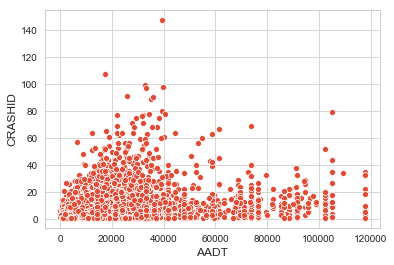

In [496]:
sns.scatterplot(data=linked, x="AADT", y="CRASHID")

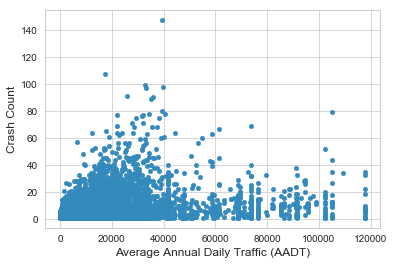

In [510]:
ax1 = linked.plot.scatter(x='AADT', y='CRASHID')
ax1.set_xlabel('Average Annual Daily Traffic (AADT)')
ax1.set_ylabel('Crash Count')
ax1.get_figure().savefig('AADT.png', dpi=300)

In [512]:
linked['AADT'].corr(linked['CRASHID'])

0.26736318402577197

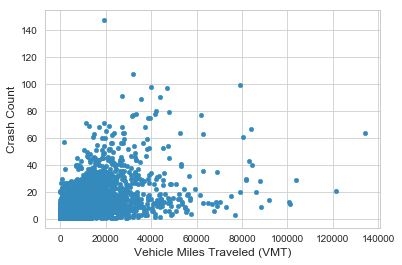

In [511]:
ax1 = linked.plot.scatter(x='VMT', y='CRASHID')
ax1.set_xlabel('Vehicle Miles Traveled (VMT)')
ax1.set_ylabel('Crash Count')
ax1.get_figure().savefig('VMT.png', dpi=300)

In [513]:
linked['VMT'].corr(linked['CRASHID'])

0.568423348330359

In [406]:
motorcycle = se_crash[se_crash['MOTORCYCLE']==1]

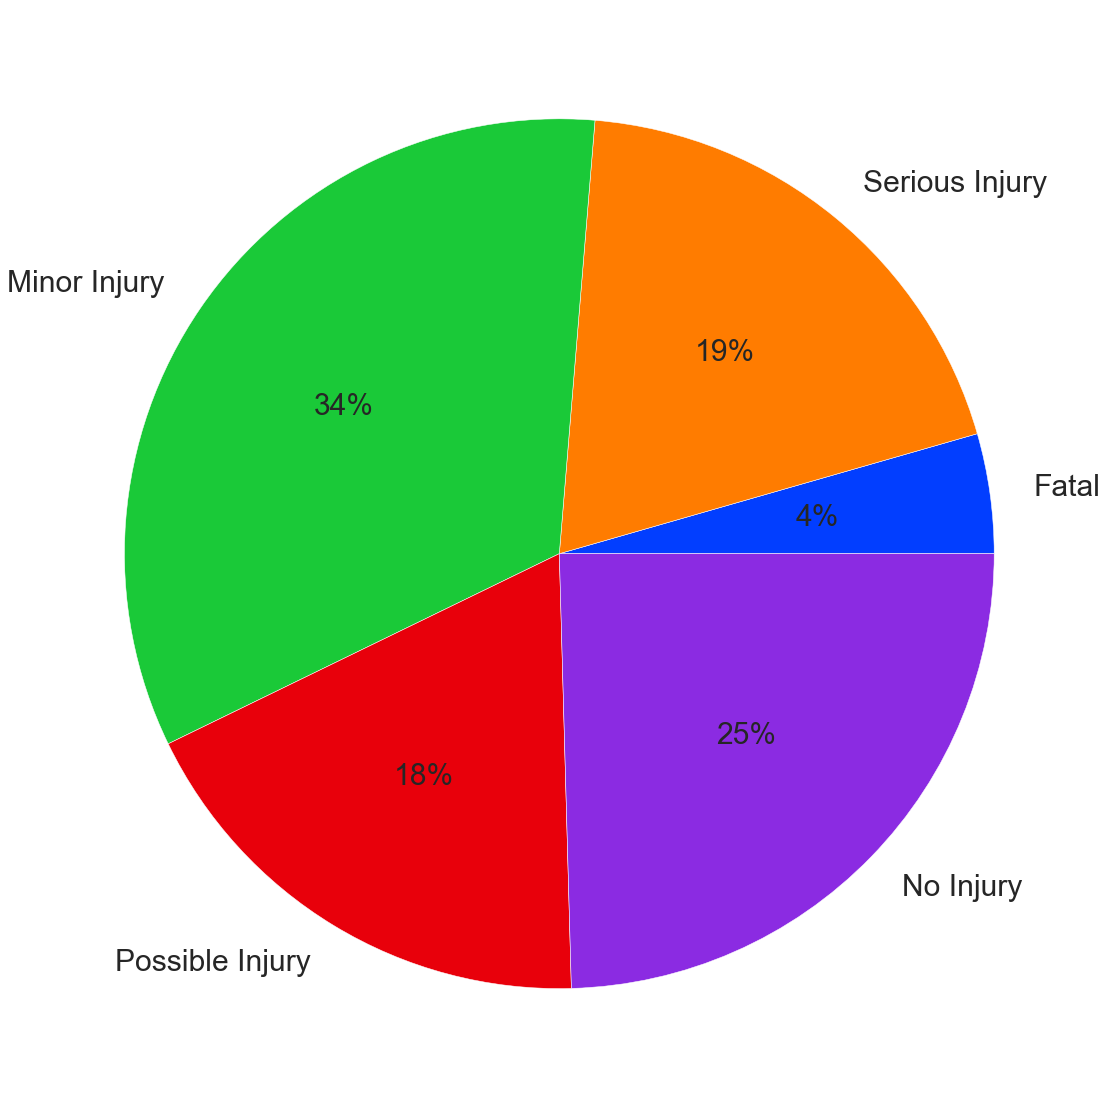

In [414]:
data = [motorcycle[motorcycle['HIGH_SEVER'] == 1].shape[0], motorcycle[motorcycle['HIGH_SEVER'] == 2].shape[0], motorcycle[motorcycle['HIGH_SEVER'] == 3].shape[0], motorcycle[motorcycle['HIGH_SEVER'] == 4].shape[0], motorcycle[motorcycle['HIGH_SEVER'] == 5].shape[0]]
pie, ax = plt.subplots(figsize=[20,20])
labels = ['Fatal', 'Serious Injury', 'Minor Injury', 'Possible Injury', 'No Injury']
colors = sns.color_palette('bright')
plt.pie(data, labels=labels,colors = colors, autopct = '%0.0f%%', textprops={'fontsize': 30})
pie.savefig('motorcycle severity.png', dpi=300)

In [415]:
print(se_crash['MOTORCYCLE'].corr(se_crash['ALCOHOL']))

0.020835393340601034


In [417]:
fatal_crashes = se_crash[se_crash['fatal'] == True]

In [446]:
fatal_crashes_filt = fatal_crashes[['DEER', 'SCHOOLBUS', 'HITNRUN', 'ALCOHOL', 'DRUG', 'COMMERCIAL', 'WORK_ZONE', 
'DISTRACTED', 'ELDERLY', 'DIS_CTRL_I', 'REDLIGHTRU', 'PEDESTRIAN', 'BICYCLE','MOTORCYCLE', 'YOUNG', 'TRAIN','EMERGENCY']]

In [447]:
fatal_counts = fatal_crashes_filt.apply(pd.Series.value_counts)


In [448]:
fatal_crashes_transposed = fatal_counts.transpose()

In [449]:
fatal_crashes_transposed

,0,1
DEER,1816,6
SCHOOLBUS,1820,2
HITNRUN,1603,219
ALCOHOL,1275,547
DRUG,1441,381
COMMERCIAL,1667,155
WORK_ZONE,1793,29
DISTRACTED,1735,87
ELDERLY,1471,351
DIS_CTRL_I,1705,117


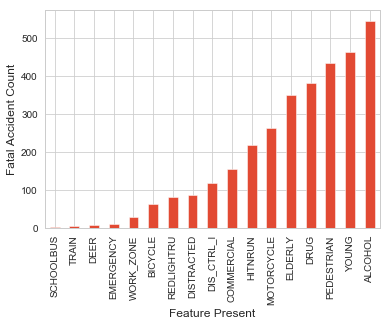

In [463]:
p = fatal_crashes_transposed.sort_values(1).plot.bar(y=1, legend=None)
p.set_xlabel('Feature Present')
p.set_ylabel('Fatal Accident Count')
p.get_figure().savefig('fatal features.png', dpi=300)

In [475]:
df2 = se_crash.groupby(['YEAR','HIGH_SEVER']).size().reset_index(name='counts')

In [485]:
df2[df2['YEAR']==2020]

,YEAR,HIGH_SEVER,counts
20,2020,1,413
21,2020,2,1707
22,2020,3,7007
23,2020,4,13658
24,2020,5,82700


In [473]:
se_crash.plot( x = 'YEAR' , y = 'HIGH_SEVER', ax = ax )

In [39]:
severity = pd.read_csv('severity.csv')

In [52]:
severity_inj = severity.copy()
severity_inj = severity_inj.drop(['No Injury'], axis=1)

In [56]:
severity_worst = severity.copy()
severity_worst = severity_worst.drop(['No Injury', 'Possible Injury', 'Minor Injury'], axis=1)

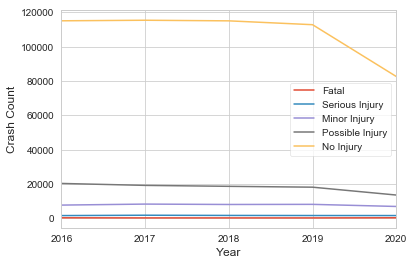

In [503]:
p = severity.plot.line(x='Year')
# p = sns.lineplot(data = severity, x ='Year')
p.set_xticks(severity.Year)
p.set_xticklabels(severity.Year)
p.set_ylabel('Crash Count')
p.set_xlabel('Year')
p.get_figure().savefig('severity.png', dpi=300, bbox_inches="tight")

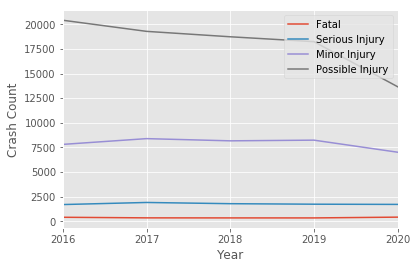

In [53]:
p = severity_inj.plot.line(x='Year')
p.set_xticks(severity_inj.Year)
p.set_xticklabels(severity_inj.Year)
p.set_ylabel('Crash Count')
p.set_xlabel('Year')
p.get_figure().savefig('severity_inj.png', dpi=300, bbox_inches="tight")

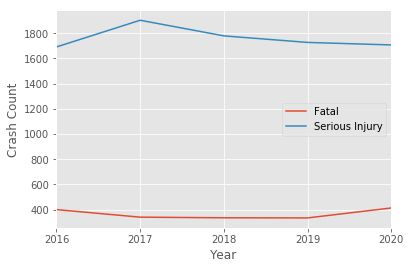

In [57]:
p = severity_worst.plot.line(x='Year')
p.set_xticks(severity_worst.Year)
p.set_xticklabels(severity_worst.Year)
p.set_ylabel('Crash Count')
p.set_xlabel('Year')
p.get_figure().savefig('severity_worst.png', dpi=300, bbox_inches="tight")

In [31]:
intersection = se_crash[se_crash['INTR_INVL_']==1]

In [518]:
intersection['REDLIGHTRU'].value_counts()

0    215170
1     17442
Name: REDLIGHTRU, dtype: int64

In [519]:
intersection['DIS_CTRL_I'].value_counts()

0    209257
1     23355
Name: DIS_CTRL_I, dtype: int64

In [520]:
intersection['DISTRACTED'].value_counts()

0    220269
1     12343
Name: DISTRACTED, dtype: int64

In [522]:
intersection[(intersection['REDLIGHTRU']==0) & (intersection['DIS_CTRL_I']==1)].shape

(5913, 88)

In [523]:
intersection[(intersection['REDLIGHTRU']==0) & (intersection['DIS_CTRL_I']==0)& (intersection['DISTRACTED']==1)].shape

(10958, 88)

In [32]:
intersection['primary'] = 'Other'

In [33]:
intersection['primary'].loc[intersection['DISTRACTED'] == 1] = 'Distracted'

In [34]:
intersection['primary'].loc[intersection['DIS_CTRL_I'] == 1] = 'Disregarded Other Signal'

In [35]:
intersection['primary'].loc[intersection['REDLIGHTRU'] == 1] = 'Disregarded Red Light'

In [36]:
intersection['primary'].value_counts()

Other                       198299
Disregarded Red Light        17442
Distracted                   10958
Disregarded Other Signal      5913
Name: primary, dtype: int64

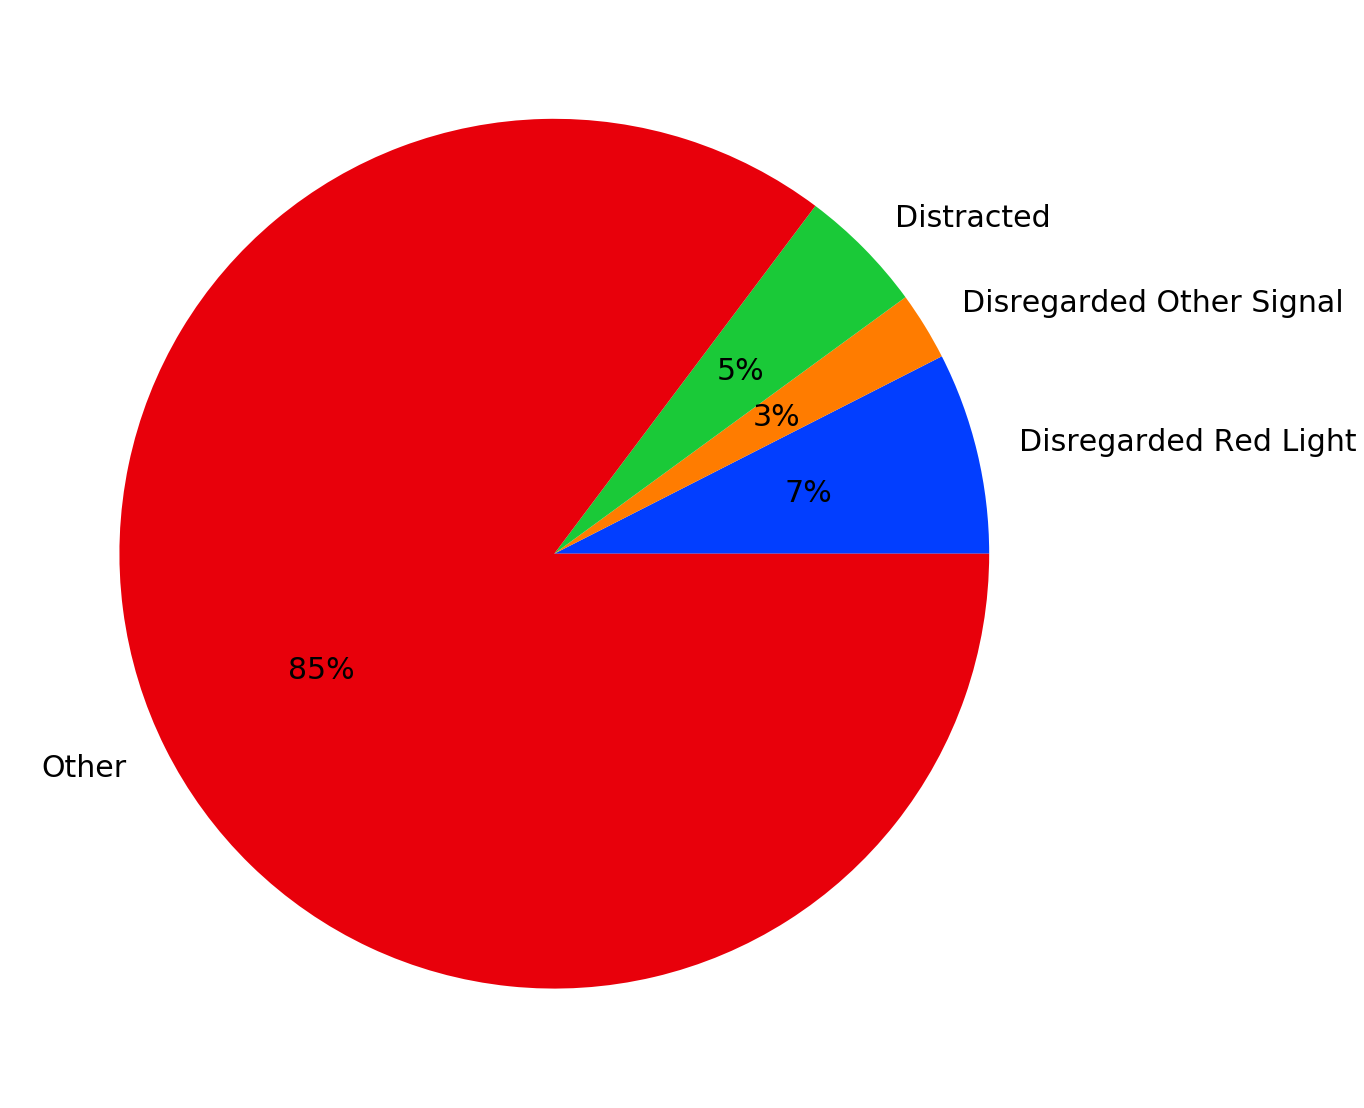

In [38]:
data = [intersection[intersection['primary'] == 'Disregarded Red Light'].shape[0], intersection[intersection['primary'] == 'Disregarded Other Signal'].shape[0], intersection[intersection['primary'] == 'Distracted'].shape[0], intersection[intersection['primary'] == 'Other'].shape[0]]
pie, ax = plt.subplots(figsize=[30,20])
labels = ['Disregarded Red Light', 'Disregarded Other Signal', 'Distracted', 'Other']
colors = sns.color_palette('bright')
plt.pie(data, labels=labels,colors = colors, autopct = '%0.0f%%', textprops={'fontsize': 30})
pie.savefig('intersection breakdown.png', dpi=300)